# Data description

#!sed 's/","/\|/g' DiccionarioDatos.csv | sed 's/"/|/g'

|Variable| Descripción|
|---|---|
|Cod Suer|Codigo Lote|
|ESTADO|Plantilla=1er.corte, SOCA>=2 cortes|
|ZAE|Zona agroecologica |
|ZC|Zona Climatica|
|Suer|Codigo Lote|
|Edad|edad de cosecha(meses)|
|Variedad|Codigo de la Variedad|
|Sac|Sacarosa %|
|Rend|Aucar x tonelada de caña %|
|Fecha|Fecha inicio corte|
|CICLO|No. de renovaciones|
|Fecha Cierre|Fecha terminacion corte|
|TCH REAL|Tons de caña por hectarea|
|Cort Act|No. corte actual|
|TCHM R|Tons de caña por hectarea por mes|
|Area Actual|Area en hectareas|
|Caña Ent|Total de toneladas de caña (TTC)|
|Año|Año de corte|
|Mes|Mes de corte|
|F C Ant|Fecha de corte anterior|
|30 DAC|Lluvia 30 dias antes de corte anterior|
|PST 0-4 Meses|Lluvia acumulada despues de corte o siembra hasta el 4to mes |
|PRC 4-9 Meses|Lluvia acumuladad entre 4 y 9 meses|
|0-15 DDC|lluvia entre 0 y 15 dias despues de corte|
|16-30 DDC|Lluvia entre 16 y 30 dias despues de corte|
|31-45 DDC||
|46-60 DDC||
|61-75 DDC||
|76-90 DDC||
|91-105 DDC||
|106-120 DDC||
|121-135 DDC||
|136-150 DDC||
|151-165 DDC||
|166-180 DDC||
|181-195 DDC||
|196-210 DDC||
|211-225 DDC||
|226-240 DDC||
|241-255 DDC||
|256-270 DDC||
|271-285 DDC||
|30 DAC Act|Lluvia 30 dias antes de corte actual|

## import the libraries

In [320]:
# import the necessary packages
import pandas as pd
import numpy as np
import argparse
import glob
from pandas import DataFrame
import sklearn
from sklearn import tree
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt


# Calcula el mean_absolute_percentage_error. El vector y_true no puede tener 0
def mape(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotScatterModel(aX, aY, bX, bY, model):
    paY = model.predict(aX)
    pbY = model.predict(bX)
    #Print the score on the train data
    print('R2')
    print({'Training': model.score(trainXX, trainY), 'Test': model.score(testXX, testY) })

    print('\nMAPE')
    print({'Training ': mape(trainY, paY), 'Test': mape(testY, pbY)})

    # declarando un objeto tipo Figura para desarrollar los subplots
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(1,2,1)
    plt.scatter(aY, paY, s = 0.1)
    plt.title('Correlation in training set')


    ax2 = fig.add_subplot(1,2,2)
    plt.scatter(bY, pbY, s = 0.1)
    plt.title('Correlation in test set')

In [321]:
#!pwd
data=pd.read_csv("./data/luvias05_18cb1.csv")

In [322]:
data.columns

Index(['Cod_Suer', 'ESTADO', 'ZAE', 'ZC', 'Suer', 'Edad', 'Variedad', 'Sac',
       'Rend', 'Fecha', 'CICLO', 'Fecha_Cierre', 'TCH_REAL', 'Cort_Act',
       'TCHM_R', 'Area_Actual', 'Cana_Ent', 'Ano', 'Mes', 'F_C_Ant', '30_DAC',
       'PST_0-4_Meses', 'PRC_4-9_Meses', '0-15_DDC', '16-30_DDC', '31-45_DDC',
       '46-60_DDC', '61-75_DDC', '76-90_DDC', '91-105_DDC', '106-120_DDC',
       '121-135_DDC', '136-150_DDC', '151-165_DDC', '166-180_DDC',
       '181-195_DDC', '196-210_DDC', '211-225_DDC', '226-240_DDC',
       '241-255_DDC', '256-270_DDC', '271-285_DDC', '30_DAC_Act'],
      dtype='object')

## Convert to data types

In [323]:
from pandas.api.types import CategoricalDtype

numericColumns = ["Edad", "Sac", "Rend", 'TCH_REAL', 'Cort_Act','TCH_REAL','TCHM_R', 
                  'Area_Actual', 'Cana_Ent', 'Ano', 'Mes', '30_DAC', 'PST_0-4_Meses', 'PRC_4-9_Meses', 
                  '0-15_DDC', '16-30_DDC', '31-45_DDC','46-60_DDC', '61-75_DDC',
                  '76-90_DDC', '91-105_DDC', '106-120_DDC', '121-135_DDC', 
                  '136-150_DDC', '151-165_DDC', '166-180_DDC', '181-195_DDC',
                  '196-210_DDC', '211-225_DDC', '226-240_DDC', '241-255_DDC', 
                  '256-270_DDC', '271-285_DDC', '30_DAC_Act']

factorColumns = ["Cod_Suer", "ESTADO", "ZAE", "ZC", "Suer", "Variedad" ]
dateColumns = ["Fecha", "Fecha_Cierre", "F_C_Ant" ]
levelColumns = ["CICLO"]
target = ["TCH_REAL", "TCH_R", "Cana_Ent", "Rend", "Sac"]

# Assign to the index the corresponding column
#data.index = data["EmployeeNumber"].values
# Convert to numeric attributes
# Nothing to do in python. Numeric is the dafault
for col in numericColumns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    

# loop to change each column to category type
for col in factorColumns:
    cat_type = CategoricalDtype(categories = None, ordered = False)
    data[col] = data[col].astype(dtype = cat_type)

# Conver to levels / Ordinals
for col in levelColumns:
    cat_type = CategoricalDtype(categories = None, ordered = True)
    data[col] = data[col].astype(dtype = cat_type)

# Conver to st ring/ Date
for col in dateColumns:
    data[col] =  pd.to_datetime(data[col], format='%d/%m/%Y')

## Seleccionamos las variables de interés

In [353]:
numericColumns = ["Edad", 'Cort_Act', 'Area_Actual', 'Mes', '30_DAC', 'PST_0-4_Meses', 'PRC_4-9_Meses', 
                  '0-15_DDC', '16-30_DDC', '31-45_DDC','46-60_DDC', '61-75_DDC',
                  '76-90_DDC', '91-105_DDC', '106-120_DDC', '121-135_DDC', 
                  '136-150_DDC', '151-165_DDC', '166-180_DDC', '181-195_DDC',
                  '196-210_DDC', '211-225_DDC', '226-240_DDC', '241-255_DDC', 
                  '256-270_DDC', '271-285_DDC', '30_DAC_Act']

factorColumns = ["ESTADO", "ZC", "Variedad"]
dateColumns = ["Fecha", "Fecha_Cierre", "F_C_Ant" ]
levelColumns = ["CICLO"]
target = ["TCH_REAL", "TCH_R", "Cana_Ent"]

dataX = data.loc[:,numericColumns + factorColumns + levelColumns]
dataY = data[target[0]].values

#Esta variable nos dice cuantos días de descanso hubo entre cosechas
dataX["descanso"] = np.floor((data["Fecha"] - data["F_C_Ant"]).dt.days - data["Edad"] * 30)

In [354]:
dataX.head(20)


,Edad,Cort_Act,Area_Actual,Mes,30_DAC,PST_0-4_Meses,PRC_4-9_Meses,0-15_DDC,16-30_DDC,31-45_DDC,...,226-240_DDC,241-255_DDC,256-270_DDC,271-285_DDC,30_DAC_Act,ESTADO,ZC,Variedad,CICLO,descanso
0,12.02,3,2.42,11,182,490,605,50,59,70,...,11,9,3,47,136.0,SOCA,6,CC011940,2,0.0
1,11.70,2,2.42,11,70,474,516,45,42,45,...,18,9,3,71,119.0,SOCA,6,CC011940,2,0.0
2,10.97,1,2.42,11,7,247,285,6,2,6,...,5,2,4,38,107.0,PLANTILLA,6,CC011940,2,0.0
3,12.35,5,2.40,11,183,351,501,15,14,15,...,4,16,21,52,185.0,SOCA,6,VARIEDADESEXP.,1,0.0
4,16.56,2,0.40,9,239,296,1067,10,20,10,...,30,138,197,82,47.0,SOCA,6,VARIEDADESEXP.,1,0.0
5,10.68,7,2.66,1,144,696,476,110,203,110,...,138,2,70,79,65.0,SOCA,6,CC8592,0,0.0
6,12.75,6,2.66,2,51,882,564,94,52,94,...,88,21,65,130,166.0,SOCA,6,CC8592,0,0.0
7,11.27,5,2.66,2,35,750,812,126,141,126,...,101,116,178,73,102.0,SOCA,6,CC8592,0,0.0
8,11.60,3,2.66,6,32,245,965,0,22,0,...,27,78,155,137,117.0,SOCA,6,CC8592,0,0.0
9,13.14,2,2.66,7,129,104,839,5,24,5,...,85,84,75,3,42.0,SOCA,6,CC8592,0,0.0


# Graficamos las variables numéricas

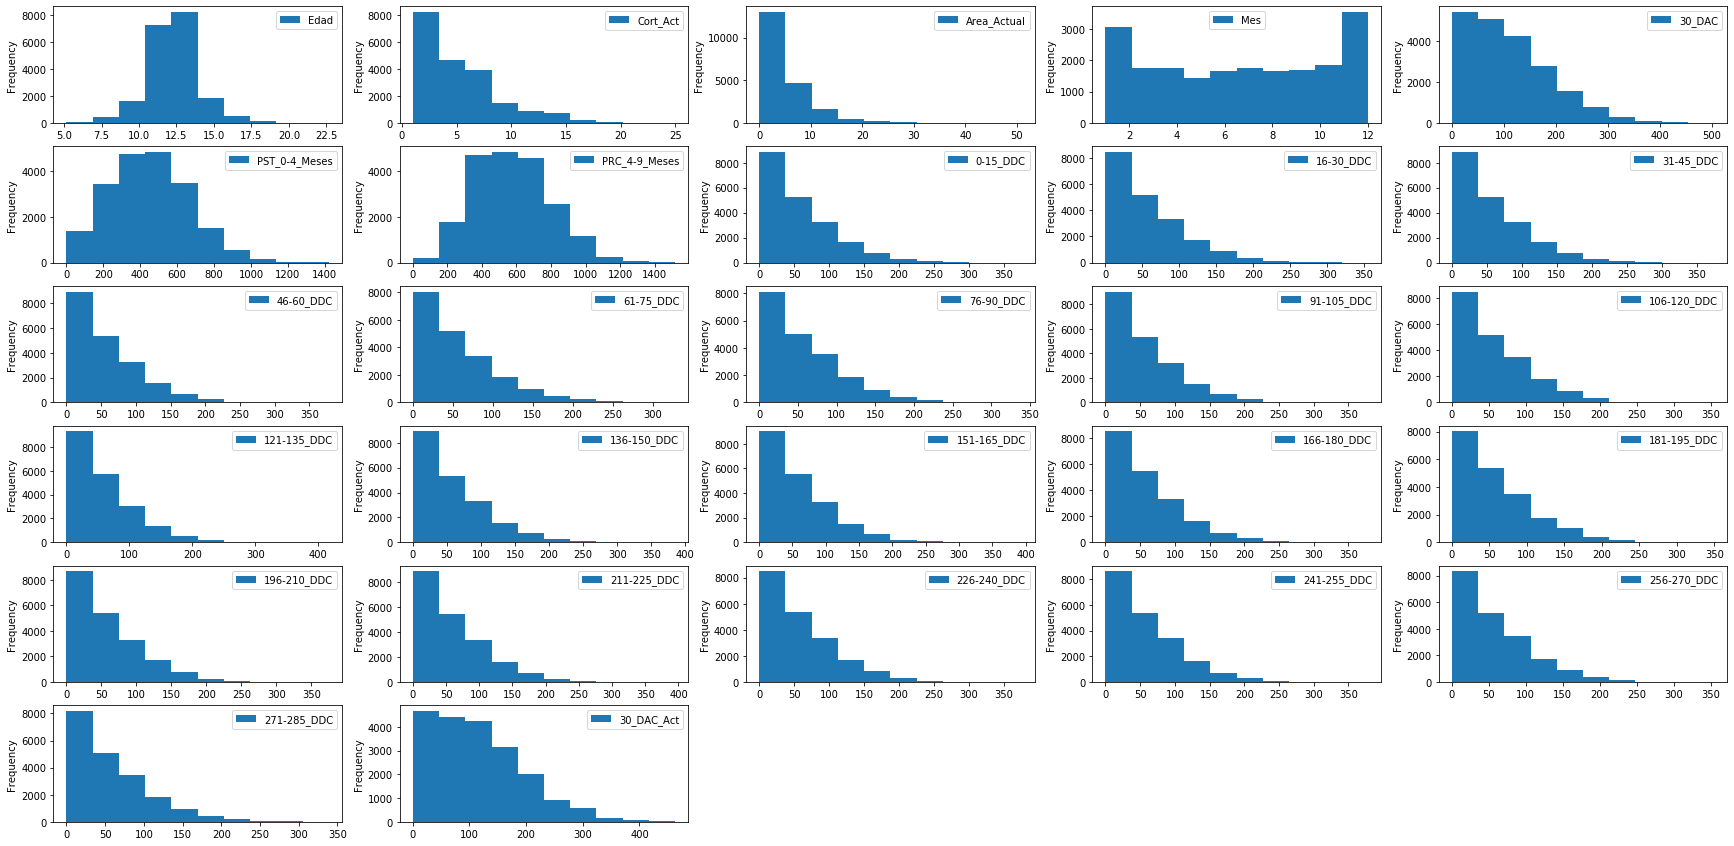

In [281]:

# declarando un objeto tipo Figura para desarrollar los subplots
fig = plt.figure(figsize=(30, 15))

x = 1
# Declarando las graficas de tipo Histograma Variables Númericas
for numAtt in numericColumns:
    # Grafica de la variable age
    ax = fig.add_subplot(6, 5, x)
    dataX[[numAtt]].plot(kind='hist', ax=ax, rwidth=1)
    x = x + 1

plt.show()

# Graficamos la variable objetivo

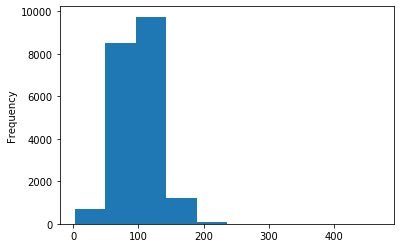

In [282]:
data[target[0]].plot(kind='hist', rwidth=1)
plt.show()

Tiene muchos outlayeres para hacer una predicción

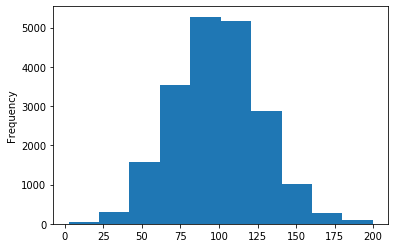

20160
20157


In [342]:
data[data[target[0]] < 200][target[0]].plot(kind='hist', rwidth=1)
plt.show()
print(sum(data[target[0]] < 200))
print(sum(data[target[0]] >= 25))

In [356]:
from operator import and_
toKeep = list(map(and_, data[target[0]] < 175, data[target[0]] >=25))
toKeep = list(map(and_, toKeep, data['Edad'] < 17.5))
toKeep = list(map(and_, toKeep, data['Area_Actual'] < 25))
toKeep = list(map(and_, toKeep, data['Cort_Act'] < 17))
toKeep = list(map(and_, toKeep, data['30_DAC'] < 350))


dataX = dataX[toKeep]
dataY = dataY[toKeep]
dataX.shape

(19381, 32)

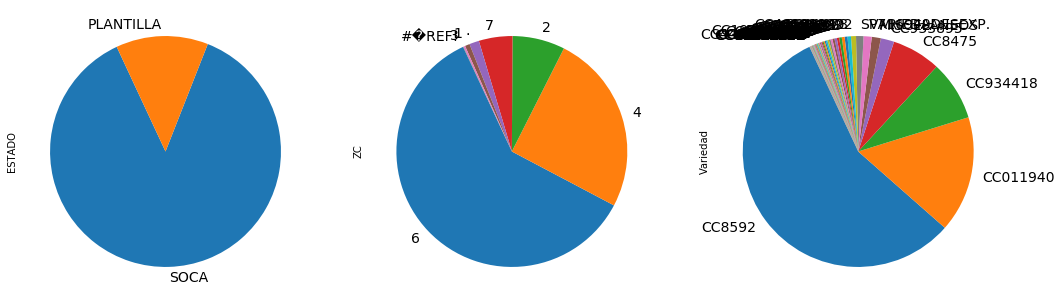

In [286]:
fig = plt.figure(figsize=(30, 20))

# Declarando las graficas de tipo Pie para Variables Categoricas
x = 6
for catAtt in factorColumns:
    # Grafica de la Variable sex
    ax = fig.add_subplot(3,5,x)
    dataX[catAtt].value_counts().plot(kind='pie', ax=ax, startangle=115, fontsize=14)
    x = x + 1


plt.show()

## Preparar datos para clasificación. Pasar factores a dummy y completar faltantes con la media de cada característica

In [357]:
data2 = dataX.copy()

for catAtt in factorColumns:
    dummies = pd.get_dummies(data2[catAtt], prefix = catAtt)
    data2 = pd.concat([data2.drop(catAtt, axis = 1), dummies], axis = 1)


for catAtt in levelColumns:
    data2[catAtt] = data2[catAtt].cat.codes

# Fill NAN in numerical attributes
foo = data2.isnull().sum()
index = 0
for f in foo:
    if f > 0:
        colname = data2.columns[index]
        print(colname)
        data2[colname] = data2[colname].fillna(data2[colname].mean())
    index = index + 1


30_DAC_Act


In [300]:
#Keep only a few varieties
data2['V_CC8592'] = data2['Variedad_CC8592']
data2['V_CC022940'] = data2['Variedad_CC011940']
data2['V_CC934418'] = data2['Variedad_CC934418']
data2['V_CC8475'] = data2['Variedad_CC8475']
data2 = data2.drop([row for row in data2.columns if row.find('Variedad') == 0], axis = 1)

In [358]:
data2.columns

Index(['Edad', 'Cort_Act', 'Area_Actual', 'Mes', '30_DAC', 'PST_0-4_Meses',
       'PRC_4-9_Meses', '0-15_DDC', '16-30_DDC', '31-45_DDC',
       ...
       'Variedad_MISCELANEOS', 'Variedad_MZC74275', 'Variedad_MZC8211',
       'Variedad_PR61632', 'Variedad_RB732223', 'Variedad_RD7511',
       'Variedad_SP61632', 'Variedad_SP716949', 'Variedad_V7151',
       'Variedad_VARIEDADESEXP.'],
      dtype='object', length=107)

In [359]:
from sklearn.preprocessing import StandardScaler

# NN is sensitive to data scale. We must normilize
scaler = StandardScaler()  
scaler.fit(data2)
y = dataY / max(dataY)

# Se divide el set de datos en dos conjuntos train y test
trainX, testX, trainY, testY = train_test_split(data2, y, test_size = 0.2)

# Don't cheat - fit only on training data
trainXX = scaler.transform(trainX)  
# apply same transformation to test data
testXX = scaler.transform(testX)

In [331]:
data2['CICLO']

0        2
1        2
2        2
3        1
4        1
        ..
20205    1
20208    0
20210    1
20212    1
20213    0
Name: CICLO, Length: 18645, dtype: int8

# Modelo de regresión con árboles de regresión con ADABoost

Los resultados de este modelo los usaremos para seleccionar los atributos más importantes


R2
{'Training': 0.8744693047735405, 'Test': 0.3423708613612878}

MAPE
{'Training ': 9.481985441939473, 'Test': 19.897526052613873}


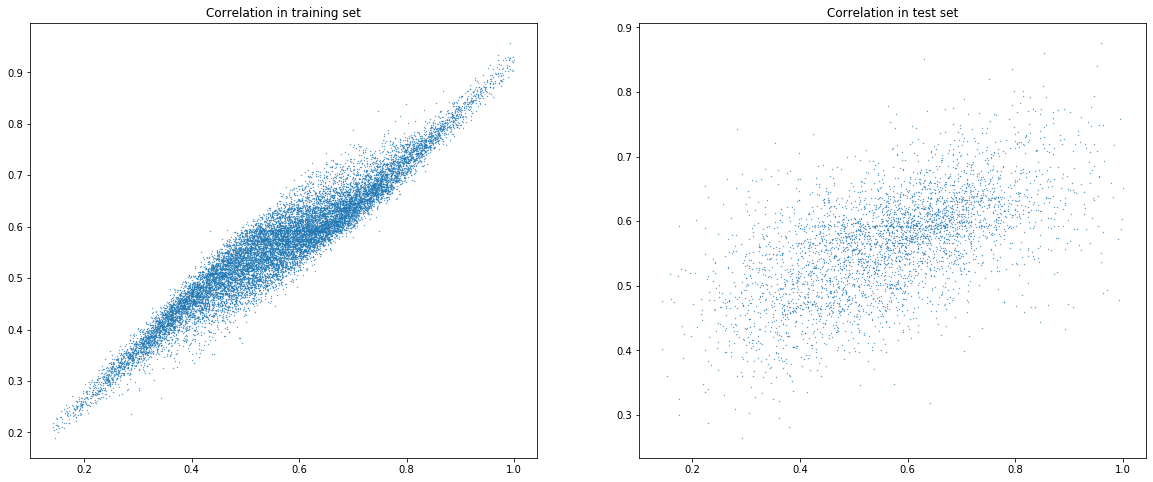

In [360]:

# ADABoost
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

modelAda = AdaBoostRegressor(DecisionTreeRegressor(max_depth=16, min_samples_leaf = 5), n_estimators=100, random_state=1)

modelAda.fit(trainXX, trainY)

# declarando un objeto tipo Figura para desarrollar los subplots
plotScatterModel(trainXX, trainY, testXX, testY, modelAda)

82


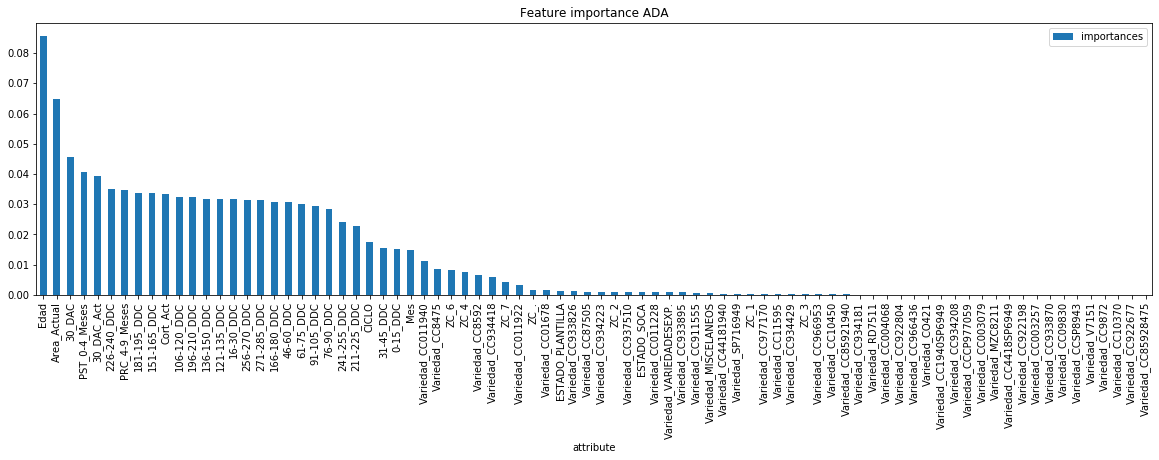

In [361]:
attributes = trainX.columns[modelAda.feature_importances_> 0]
importances = modelAda.feature_importances_[modelAda.feature_importances_> 0]

reportOfAttributes = pd.DataFrame({'attribute': attributes, 'importances': importances})
reportOfAttributes = reportOfAttributes.sort_values(by = 'importances',  ascending=False)
reportOfAttributes = reportOfAttributes.set_index('attribute')
reportOfAttributes.plot(kind='bar', figsize=(20, 5)).set_title('Feature importance ADA')
print(sum(modelAda.feature_importances_> 0))

Usaremos los atributos más importantes encontrados por este modelo para correr los demás modelos

In [362]:
# Usemos los mejores atributos del modelo ADABoost para entrenar el resto de modelos de aqui en adelante
data2.shape
data3 = data2.loc[:, data2.columns[modelAda.feature_importances_> 0].values]
data3.shape

(19381, 82)

# Creamos 2 conjuntos de datos para entrenamiento y pruebas con las variables seleccionadas

In [371]:
from sklearn.preprocessing import StandardScaler

# NN is sensitive to data scale. We must normilize
scaler2 = StandardScaler()
scaler2.fit(data3)  

# Se divide el set de datos en dos conjuntos train y test
y = dataY / max(dataY)
x = scaler2.transform(data3)
trainXX, testXX, trainY, testY = train_test_split(x, y, test_size = 0.1)


# Modelo de regresión con redes neuronales

R2
{'Training': 0.5170548637170242, 'Test': 0.20382375636656225}

MAPE
{'Training ': 17.01687460733209, 'Test': 23.036148248023956}


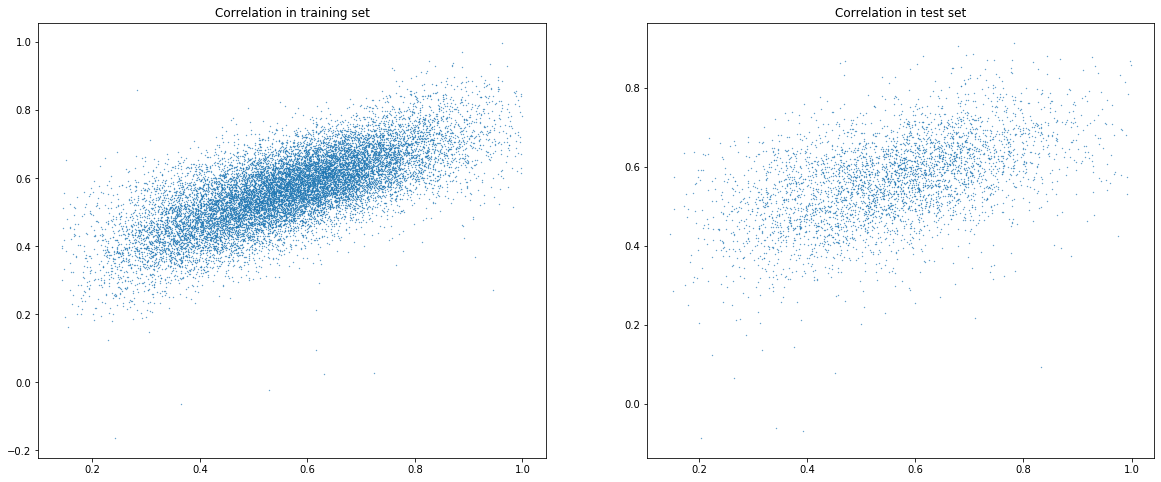

In [352]:
from sklearn.neural_network import MLPRegressor


model3 = MLPRegressor(solver='adam', tol = 1e-8, learning_rate_init=0.001, alpha=0.001, activation = 'relu', max_iter=3000,
                     hidden_layer_sizes = (50, 20, 10), verbose = False)

model3.fit(trainXX, trainY)                         

plotScatterModel(trainXX, trainY, testXX, testY, model3)


In [367]:
# No corra esto a menos que quiera esperar mucho. El resultado está abajo
# parameters_for_testing = {alpha: [0.4, 0.2, 0.1, 0.01], tol= [1e-5, 1e-6, 1e-7, 1e-8], learning_rate_init: [1e-2, 1e-3, 1e-4,1e-5, 1e-6]}


parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03],
    'min_child_weight':[1.5,6,10,20],
    'learning_rate':[0.07],
    'max_depth':[15],
    'n_estimators':[100],
    'reg_alpha':[1e-2,  0.75],
    'reg_lambda':[1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

                  
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=100, max_depth=12,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs = 6, iid = False, verbose=10, scoring = 'neg_median_absolute_error')
gsearch1.fit(trainXX, trainY)
#print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   25.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   31.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 10.9min
[Parallel(

[16:36:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best params
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.07, 'max_depth': 15, 'min_child_weight': 20, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.45, 'subsample': 0.95}
best score
-0.07948803384321813


# Probemos XGBoost con los parametros optimizados

R2
{'Training': 0.9040996439113792, 'Test': 0.352944935736797}

MAPE
{'Training ': 7.357835971115649, 'Test': 19.8626090106788}


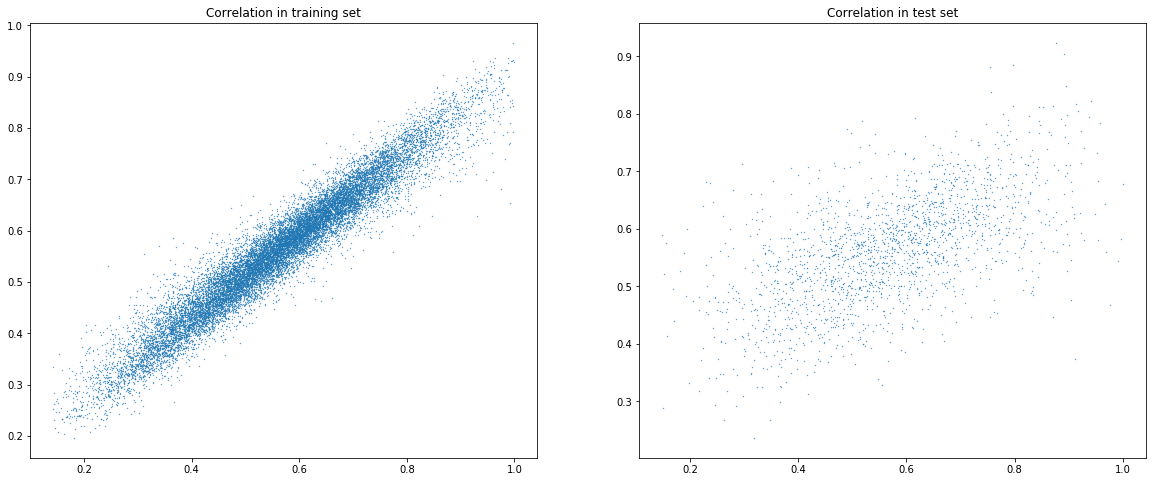

In [373]:
modelXGB = xgboost.XGBRegressor(colsample_bytree=0.8,
                 gamma=0.0,                 
                 learning_rate=0.07,
                 max_depth=15,
                 min_child_weight=20,
                 n_estimators=150,                                                                    
                 reg_alpha=0.01,
                 reg_lambda=0.45,
                 subsample=0.95,
                 seed=110,
                 objective='reg:squarederror')

modelXGB.fit(trainXX, trainY)

plotScatterModel(trainXX, trainY, testXX, testY, modelXGB)